<a href="https://colab.research.google.com/github/anshupandey/Computer-Vision/blob/master/semantic_Segmentation_with_UNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset Preparation

In [1]:
!wget -q https://www.dropbox.com/s/ghvpyv3hbw67cpt/camvid.tar

In [2]:
!wget -q http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/data/label_colors.txt

In [3]:
!tar -xvf camvid.tar  > /dev/null; echo " done."

 done.


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import os
import cv2

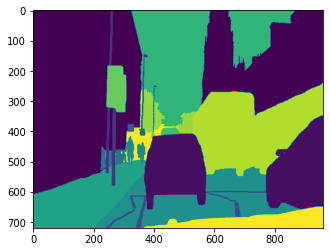

In [5]:
mask = plt.imread("/content/camvid/labels/0001TP_006690_P.png")
plt.imshow(mask)
plt.show()

# Modelling the UNET

In [6]:
from tensorflow.keras import models,layers

In [7]:
input_layer = layers.Input(shape=(128,128,3),name="image_input")

# Encoder Segment
#block1
x = layers.Conv2D(filters=64,kernel_size=(3,3),padding='same')(input_layer)
x = layers.BatchNormalization()(x)
x = layers.Activation(activation='relu')(x)
x = layers.Conv2D(filters=64,kernel_size=(3,3),padding='same')(x)
x = layers.BatchNormalization()(x)
block1 = layers.Activation(activation='relu')(x)

#block2
x = layers.MaxPooling2D(pool_size=(2,2))(block1)
x = layers.Conv2D(filters=128,kernel_size=(3,3),padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation(activation='relu')(x)
x = layers.Conv2D(filters=128,kernel_size=(3,3),padding='same')(x)
x = layers.BatchNormalization()(x)
block2 = layers.Activation(activation='relu')(x)

#block3
x = layers.MaxPooling2D(pool_size=(2,2))(block2)
x = layers.Conv2D(filters=256,kernel_size=(3,3),padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation(activation='relu')(x)
x = layers.Conv2D(filters=256,kernel_size=(3,3),padding='same')(x)
x = layers.BatchNormalization()(x)
block3 = layers.Activation(activation='relu')(x)

#block4
x = layers.MaxPooling2D(pool_size=(2,2))(block3)
x = layers.Conv2D(filters=512,kernel_size=(3,3),padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation(activation='relu')(x)
x = layers.Conv2D(filters=512,kernel_size=(3,3),padding='same')(x)
x = layers.BatchNormalization()(x)
block4 = layers.Activation(activation='relu')(x)
block4 = layers.Dropout(0.5)(block4)

## bottleneck
x = layers.MaxPooling2D(pool_size=(2,2))(block4)
x = layers.Conv2D(filters=1024,kernel_size=(3,3),padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation(activation='relu')(x)
x = layers.Conv2D(filters=1024,kernel_size=(3,3),padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation(activation='relu')(x)
bottleneck = layers.Dropout(0.5)(x)

## Decoder segment

#block5
x = layers.Conv2DTranspose(filters=512,kernel_size=(3,3),padding='same',strides=(2,2))(bottleneck)
x = layers.concatenate([x,block4],axis=3)
x = layers.Conv2D(filters=512,kernel_size=(3,3),padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation(activation='relu')(x)
x = layers.Conv2D(filters=512,kernel_size=(3,3),padding='same')(x)
x = layers.BatchNormalization()(x)
block5 = layers.Activation(activation='relu')(x)
block5 = layers.Dropout(0.5)(block5)

#block6
x = layers.Conv2DTranspose(filters=256,kernel_size=(3,3),padding='same',strides=(2,2))(block5)
x = layers.concatenate([x,block3],axis=3)
x = layers.Conv2D(filters=256,kernel_size=(3,3),padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation(activation='relu')(x)
x = layers.Conv2D(filters=256,kernel_size=(3,3),padding='same')(x)
x = layers.BatchNormalization()(x)
block6 = layers.Activation(activation='relu')(x)

#block7
x = layers.Conv2DTranspose(filters=128,kernel_size=(3,3),padding='same',strides=(2,2))(block6)
x = layers.concatenate([x,block2],axis=3)
x = layers.Conv2D(filters=128,kernel_size=(3,3),padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation(activation='relu')(x)
x = layers.Conv2D(filters=128,kernel_size=(3,3),padding='same')(x)
x = layers.BatchNormalization()(x)
block7 = layers.Activation(activation='relu')(x)

#block8
x = layers.Conv2DTranspose(filters=64,kernel_size=(3,3),padding='same',strides=(2,2))(block7)
x = layers.concatenate([x,block1],axis=3)
x = layers.Conv2D(filters=64,kernel_size=(3,3),padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation(activation='relu')(x)
x = layers.Conv2D(filters=64,kernel_size=(3,3),padding='same')(x)
x = layers.BatchNormalization()(x)
block8 = layers.Activation(activation='relu')(x)

# outputlayer
output_layer = layers.Conv2D(filters=32,kernel_size=(1,1),activation='softmax')(block8)

model = models.Model(inputs=input_layer,outputs=output_layer)
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 1792        image_input[0][0]                
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 64) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

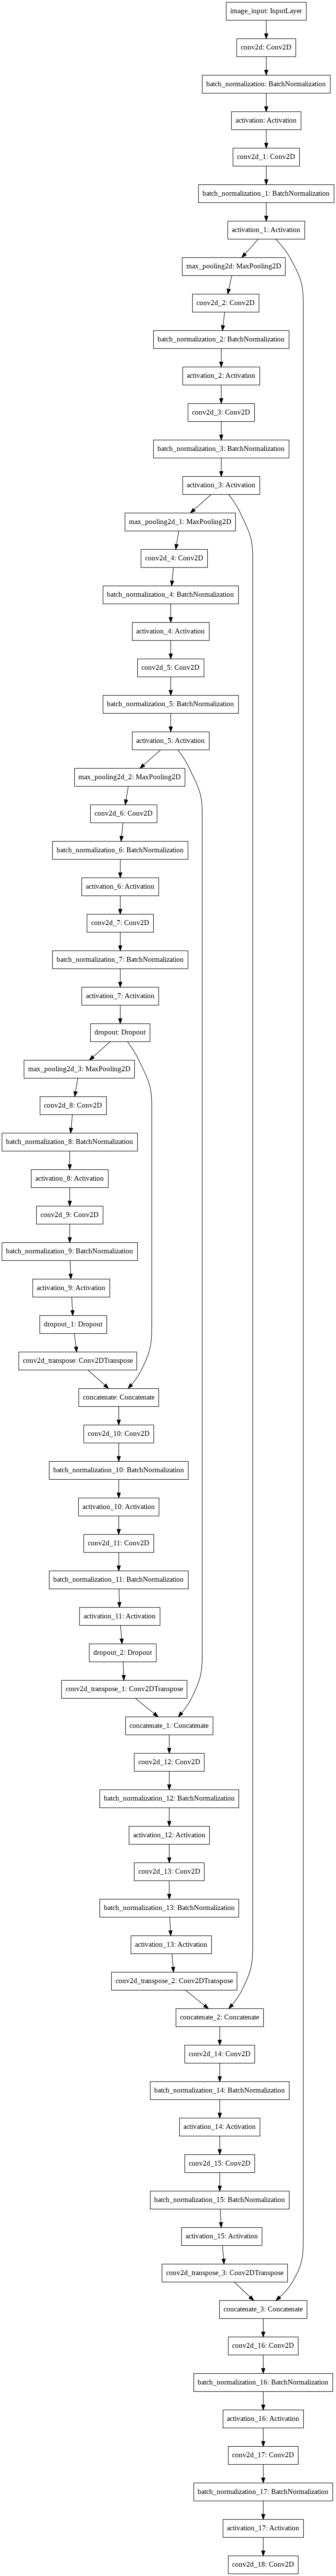

In [8]:
from tensorflow.keras.utils import plot_model
plot_model(model)

In [9]:
img_dir = "/content/camvid/images"
mask_dir = "/content/camvid/labels"
img_list = os.listdir(img_dir)
mask_list = os.listdir(mask_dir)
print(len(mask_list))
print(len(img_list))

701
702


In [10]:
os.remove(img_dir+"/test.txt")
img_list = os.listdir(img_dir)
mask_list = os.listdir(mask_dir)
print(len(mask_list))
print(len(img_list))

701
701


In [11]:
img_list = os.listdir(img_dir)
mask_list = os.listdir(mask_dir)
print(len(mask_list))
print(len(img_list))

701
701


# Custom image Data Generator

In [12]:
from tensorflow.keras.utils import Sequence

samples = len(mask_list)
batch_size=8
class custom_image_data_generator(Sequence):
  def __init__(self,xd,yd,batch_size):
    self.x,self.y = xd,yd
    self.batch_size = batch_size
    
  def __len__(self):
    return int(np.ceil(len(self.x) / float(self.batch_size)))

  def __getitem__(self, idx):
        idx = np.random.randint(0,samples,batch_size)    
        batchx,batchy = [],[]
        for i in idx:
          img = image.load_img(img_dir+"/"+img_list[i],target_size=(128,128))
          img = image.img_to_array(img)/255
          mask = image.load_img(mask_dir+"/"+img_list[i][:-4]+"_P.png",target_size=(128,128),grayscale=True)
          mask = image.img_to_array(mask)
          batchx.append(img)
          batchy.append(mask)
        return np.array(batchx),np.array(batchy)

In [13]:
model.compile(optimizer='adam',loss="sparse_categorical_crossentropy",
              metrics=['sparse_categorical_accuracy'])
train_generator = custom_image_data_generator(img_list,mask_list,batch_size=8)
model.fit_generator(train_generator,epochs=10,verbose=True )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


Epoch 1/10
88/88 [==============================] - 61s 267ms/step - loss: 1.8295 - sparse_categorical_accuracy: 0.5574
Epoch 2/10
88/88 [==============================] - 24s 267ms/step - loss: 0.8685 - sparse_categorical_accuracy: 0.7629
Epoch 3/10
88/88 [==============================] - 24s 268ms/step - loss: 0.7330 - sparse_categorical_accuracy: 0.7975
Epoch 4/10
88/88 [==============================] - 24s 270ms/step - loss: 0.6538 - sparse_categorical_accuracy: 0.8168
Epoch 5/10
88/88 [==============================] - 24s 268ms/step - loss: 0.6378 - sparse_categorical_accuracy: 0.8185
Epoch 6/10
88/88 [==============================] - 24s 268ms/step - loss: 0.5988 - sparse_categorical_accuracy: 0.8287
Epoch 7/10
88/88 [==============================] - 24s 270ms/step - loss: 0.5470 - sparse_categorical_accuracy: 0.8420
Epoch 8/10
88/88 [==============================] - 24s 269ms/step - loss: 0.5278 - sparse_categorical_accuracy: 0.8475
Epoch 9/10
88/88 [======================

# Making Predictions

In [14]:
!wget -q https://raw.githubusercontent.com/anshupandey/Computer-Vision/master/Image%20Segmentation/test_images.zip

In [15]:
!unzip test_images.zip

Archive:  test_images.zip
  inflating: test_images/0016E5_07981.png  
  inflating: test_images/0016E5_08003.png  


In [16]:

test_dir = 'test_images/'
image_list = os.listdir(test_dir)
print(f'{len(image_list)} frames found')

2 frames found


## Preparing labels and colors

In [17]:
def clean_labels(line):
  if len(line.strip().split("\t"))==2:
    col,lab = line.strip().split("\t")
  else:
    col,_,lab = line.strip().split("\t")
  col = tuple(int(i) for i in col.split(" "))
  return col,lab

In [18]:
labels = open("label_colors.txt").readlines()
labels[:5]

['64 128 64\tAnimal\n',
 '192 0 128\tArchway\n',
 '0 128 192\tBicyclist\n',
 '0 128 64\tBridge\n',
 '128 0 0\t\tBuilding\n']

In [19]:
col,lab = labels[0].strip().split("\t")
print(col)
print(lab)
col = tuple(int(i) for i in col.split(" "))
print(col)

64 128 64
Animal
(64, 128, 64)


In [20]:
labels[4].strip().split("\t")

['128 0 0', '', 'Building']

In [21]:
clean_labels(labels[0])

((64, 128, 64), 'Animal')

In [22]:
label_colors,label_names = zip(*[clean_labels(line) for line in labels])
label_colors,label_names = list(label_colors),list(label_names)
print(len(label_colors))

32


In [23]:
label_colors[:5],label_names[:5]

([(64, 128, 64), (192, 0, 128), (0, 128, 192), (0, 128, 64), (128, 0, 0)],
 ['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building'])

In [24]:
dictionary = {K:V for K,V in enumerate(label_colors)}
print(dictionary)

{0: (64, 128, 64), 1: (192, 0, 128), 2: (0, 128, 192), 3: (0, 128, 64), 4: (128, 0, 0), 5: (64, 0, 128), 6: (64, 0, 192), 7: (192, 128, 64), 8: (192, 192, 128), 9: (64, 64, 128), 10: (128, 0, 192), 11: (192, 0, 64), 12: (128, 128, 64), 13: (192, 0, 192), 14: (128, 64, 64), 15: (64, 192, 128), 16: (64, 64, 0), 17: (128, 64, 128), 18: (128, 128, 192), 19: (0, 0, 192), 20: (192, 128, 128), 21: (128, 128, 128), 22: (64, 128, 192), 23: (0, 0, 64), 24: (0, 64, 64), 25: (192, 64, 128), 26: (128, 128, 0), 27: (192, 128, 192), 28: (64, 0, 64), 29: (192, 192, 0), 30: (0, 0, 0), 31: (64, 192, 0)}


In [25]:
# Assign different objects with colurs with the help of id2code
def color_label(a): 
    print(a.shape)
    r,c=a.shape
    res = np.zeros((r,c,3), 'uint8')
    for j in range(r): 
        for k in range(c):
            var = dictionary[a[j,k]]
            res[j,k] = var
    return res

(360, 480)
(360, 480)


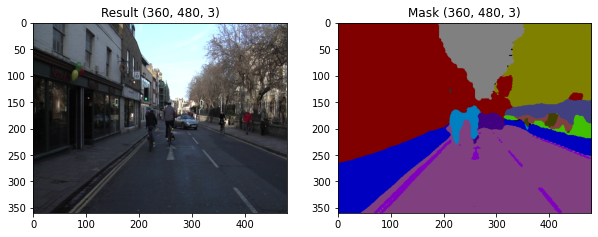

In [36]:
test = image.load_img('test_images/0016E5_07981.png')
imh = image.img_to_array(test)
dims = imh.shape
x = cv2.resize(imh, (128, 128))
x = np.float32(x)/255.
##########get the predictions
z = model.predict(np.expand_dims(x, axis=0))

z = np.squeeze(z)
z = cv2.resize(z, (dims[1], dims[0]))
y = np.argmax(z, axis=2)
print(y.shape)
vb= color_label(y)

fig = plt.figure(figsize=(10, 15))
ax = fig.add_subplot(121)
ax.set_title(f'Result {imh.shape}')
ax.imshow(np.uint8(imh))

ax2 = fig.add_subplot(122)
ax2.set_title(f'Mask {vb.shape}')
ax2.imshow(vb)